In [11]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# Aquisição dos dados

Para esse trabalho, 

In [12]:
START_DATE = "2011-01-01"
END_DATE = "2022-01-01"

URL = "https://en.wikipedia.org/wiki/List_of_steel_producers"

df = pd.read_html(URL)[0]
df = df[[column for column in df.columns if 'Unnamed' not in column]].copy()

df.head()

,Ranking (2019),Company,Country,2019[1],2018[2],2017[3],2016[4],2015[5],2014[6],2013[7],2012[8],2011[9],2010[9],2009[9],2008[9],2007[9]
0,1,ArcelorMittal,Luxembourg,97.1,96.4,97,95.5,97.1,98.1,96.1,93.6,97.2,98.2,77.5,103.3,116.4
1,2,China Baowu Steel Group,China,95.5,67.4,65.4,63.8,60.7,76.4,83.2,79.2,81,-,-,-,-
2,3,Nippon Steel,Japan,51.7,49.2,47.4,46.2,46.3,49.3,50.1,47.9,33.4[10],35.0[10],26.5[10],37.5[10],35.7[10]
3,4,Hesteel Group,China,46.6,46.8,45.6,46.2,47.7,47.1,45.8,42.8,44.4,52.9[11],40.2[12],33.3,31.1
4,5,POSCO,South Korea,43.1,42.9,42.2,41.6,42,41.4,38.4,39.9,39.1,35.4,31.1,34.7,31.1


In [13]:
dct_steel = {
    "CSNA3.SA": {"name":"Companhia Siderúrgica Nacional", "market": "Bovespa", "currency": "BRL"},
    "MT":{"name": "ArcelorMittal NYSE", "market": "NYSE", "currency": "USD"},
    "MT.AS":{"name": "ArcelorMittal Amsterdam", "market": "Amsterdam Delayed Price", "currency": "EUR"},
    "5401.T":{"name": "Nippon Steel Corporation", "market": "Nikkey", "currency": "JPY"},
    "000709.SZ":{"name": "Hesteel Group", "market":"Shenzhen", "currency": "CNY"},
    "PKX":{"name": "POSCO", "market":"NYSE", "currency": "USD"},
    "BRL=X":{"name": "BRL to USD", "market":"currency", "currency": "BRL"}
}

pd.DataFrame.from_dict(dct_steel, orient="index")

,name,market,currency
CSNA3.SA,Companhia Siderúrgica Nacional,Bovespa,BRL
MT,ArcelorMittal NYSE,NYSE,USD
MT.AS,ArcelorMittal Amsterdam,Amsterdam Delayed Price,EUR
5401.T,Nippon Steel Corporation,Nikkey,JPY
000709.SZ,Hesteel Group,Shenzhen,CNY
PKX,POSCO,NYSE,USD
BRL=X,BRL to USD,currency,BRL


In [14]:
URL_STEEL = "https://worldsteelprices.com/"

df = pd.read_html(URL_STEEL)[0]
df = df[[column for column in df.columns if 'Unnamed' not in column]].copy()

df.head()


,Month,CARBON STEEL PRICE,CARBON STEEL INDEX,STAINLESS STEEL 304 PRICE,STAINLESS STEEL 304 INDEX
0,Apr-20,614,153.9,2314,123.3
1,Mar-20,642,160.9,2345,124.9
2,Feb-20,643,161.2,2368,126.2
3,Jan-20,644,161.4,2391,127.4
4,Dec-19,620,155.4,2492,132.8


In [15]:
def downloading_stocks_data(dct, start_date: str="2011-01-01", end_date: str="2022-01-01") -> pd.DataFrame:
    lst_index = dct.keys()
    df = yf.download(list(dct.keys())[0], start=start_date, end=end_date, show_errors=False)[["Close"]]
    df.columns = [dct[list(dct.keys())[0]]["name"]]

    for market_index in list(dct.keys())[1:]:
        df_temp = yf.download(market_index, start=start_date, end=end_date)[["Close"]]
        df_temp.columns = [dct[market_index]["name"]]
        df = df.merge(df_temp, how='left', left_index=True, right_index=True)
    
    df.dropna(how='all', axis=0, inplace=True)
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

    return df

df = downloading_stocks_data(dct_steel)
df.head(10)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Companhia Siderúrgica Nacional,ArcelorMittal NYSE,ArcelorMittal Amsterdam,Nippon Steel Corporation,Hesteel Group,POSCO,BRL to USD
Date,,,,,,,
2011-01-03,27.299999,115.440002,59.049683,2930.0,3.81,108.180000,1.6155
2011-01-04,28.049999,113.220001,57.460354,2930.0,3.81,111.269997,1.6465
2011-01-05,28.750000,110.879997,56.645313,2900.0,3.78,112.400002,1.6675
2011-01-06,28.870001,107.669998,56.146099,2960.0,3.78,111.809998,1.6750
2011-01-07,29.049999,105.059998,55.422752,2920.0,3.84,108.599998,1.6859
2011-01-10,29.020000,103.589996,54.098312,2920.0,3.76,107.709999,1.6355
2011-01-11,29.549999,105.540001,55.066170,3030.0,3.80,110.769997,1.6890
2011-01-12,30.150000,109.559998,56.614746,3010.0,3.89,111.099998,1.6416
2011-01-13,29.700001,108.330002,55.555195,3020.0,3.84,106.410004,1.6247


In [16]:
df_return_in_period = df.copy()

for column in df_return_in_period.columns:
    df_return_in_period[column] = df_return_in_period[column]/df_return_in_period.loc[min(df_return_in_period.index), column]

df_return_in_period.tail()

,Companhia Siderúrgica Nacional,ArcelorMittal NYSE,ArcelorMittal Amsterdam,Nippon Steel Corporation,Hesteel Group,POSCO,BRL to USD
Date,,,,,,,
2021-06-08,1.604396,0.281532,0.449621,0.660922,0.645669,0.705953,3.122996
2021-06-09,1.640293,0.280665,0.448267,0.658020,0.656168,0.691533,3.116620
2021-06-10,1.642125,0.282311,0.452246,0.666041,0.658793,0.698465,3.133086
2021-06-11,1.666667,0.287422,0.462323,0.669113,0.669291,0.717693,3.128753
2021-06-14,1.652747,0.283004,0.455972,0.665188,0.669291,0.704659,3.167441


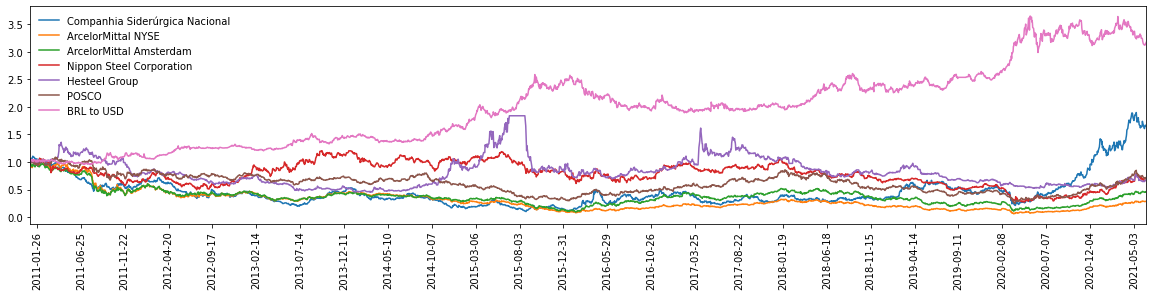

In [17]:
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(111)


for market_index in df_return_in_period.columns:
    ax.plot(df_return_in_period[market_index], label=market_index)

date_min = df_return_in_period.index.min()
date_max = df_return_in_period.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

In [18]:
def daily_return(df):
    lst = [column for column in df.columns if 'rt_' not in column]
    for column in df.columns:
        df['rt_'+column] = (np.log(df[column]) - np.log(df[column].shift(periods=1)))*100
    return df

df = daily_return(df)[1:]
df.head(2)

,Companhia Siderúrgica Nacional,ArcelorMittal NYSE,ArcelorMittal Amsterdam,Nippon Steel Corporation,Hesteel Group,POSCO,BRL to USD,rt_Companhia Siderúrgica Nacional,rt_ArcelorMittal NYSE,rt_ArcelorMittal Amsterdam,rt_Nippon Steel Corporation,rt_Hesteel Group,rt_POSCO,rt_BRL to USD
Date,,,,,,,,,,,,,,
2011-01-04,28.049999,113.220001,57.460354,2930.0,3.81,111.269997,1.6465,2.710193,-1.941810,-2.728396,0.000000,0.000000,2.816314,1.900733
2011-01-05,28.750000,110.879997,56.645313,2900.0,3.78,112.400002,1.6675,2.464916,-2.088433,-1.428596,-1.029169,-0.790517,1.010430,1.267369


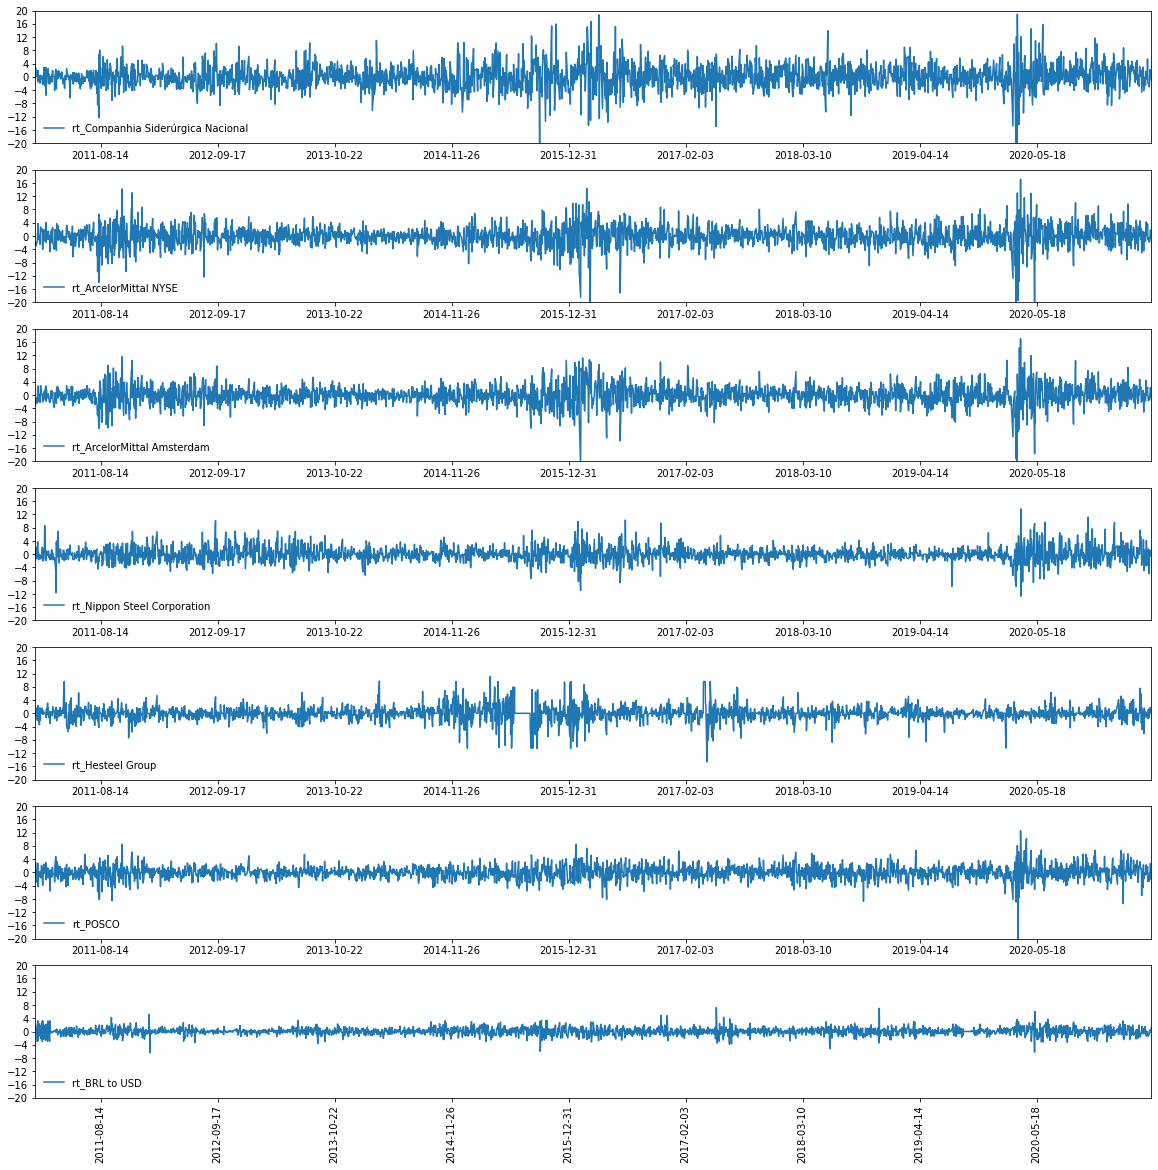

In [19]:
fig, axs = plt.subplots(nrows=len([column for column in df.columns if 'rt_' in column]), figsize=(20,20))

for i, column in enumerate(df[[column for column in df.columns if 'rt_' in column]]):
    axs[i].plot(df[column], label=column)
    axs[i].xaxis.set_major_locator(plt.MaxNLocator(10))
    axs[i].yaxis.set_major_locator(plt.MaxNLocator(10))
    axs[i].set_ylim(-20, 20)
    axs[i].set_xlim(left=date_min, right=date_max)
    axs[i].legend(loc='lower left', frameon=False)

plt.xticks(rotation=90)
plt.show();

### Agrupamento dos $r_{t}$

**Agrupamentos uniformes**

In [33]:
def uniform_clustering(df: pd.DataFrame, lst_columns: list, only_clusters: bool=True) -> pd.DataFrame:
    """This function creates the target "Cluster" according to the limits described in article."""
    lst_columns = [column for column in lst_columns if 'cluster' not in column]
    for column in lst_columns:
        desc = df.iloc[0,:].describe().T
        conditions  = [df[column] < 0, df[column] >= 0]
        choices = [ 0, 1]
        df["cluster_"+column] = np.select(conditions, choices, default=np.nan)

    if only_clusters:
        df = df[[column for column in df.columns if "cluster" in column]]

    return df

In [34]:

df_temp = uniform_clustering(df, [column for column in df.columns if "rt_" in column], only_clusters=False)
df_temp.head()

,Companhia Siderúrgica Nacional,ArcelorMittal NYSE,ArcelorMittal Amsterdam,Nippon Steel Corporation,Hesteel Group,POSCO,BRL to USD,rt_Companhia Siderúrgica Nacional,rt_ArcelorMittal NYSE,rt_ArcelorMittal Amsterdam,...,rt_Hesteel Group,rt_POSCO,rt_BRL to USD,cluster_rt_Companhia Siderúrgica Nacional,cluster_rt_ArcelorMittal NYSE,cluster_rt_ArcelorMittal Amsterdam,cluster_rt_Nippon Steel Corporation,cluster_rt_Hesteel Group,cluster_rt_POSCO,cluster_rt_BRL to USD
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,28.049999,113.220001,57.460354,2930.0,3.81,111.269997,1.6465,2.710193,-1.941810,-2.728396,...,0.000000,2.816314,1.900733,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2011-01-05,28.750000,110.879997,56.645313,2900.0,3.78,112.400002,1.6675,2.464916,-2.088433,-1.428596,...,-0.790517,1.010430,1.267369,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2011-01-06,28.870001,107.669998,56.146099,2960.0,3.78,111.809998,1.6750,0.416526,-2.937753,-0.885205,...,0.000000,-0.526297,0.448763,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2011-01-07,29.049999,105.059998,55.422752,2920.0,3.84,108.599998,1.6859,0.621543,-2.453938,-1.296700,...,1.574834,-2.912959,0.648639,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2011-01-10,29.020000,103.589996,54.098312,2920.0,3.76,107.709999,1.6355,-0.103319,-1.409083,-2.418721,...,-2.105339,-0.822897,-3.035099,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
def create_rt_list(lst: list) -> list:
    rt = ["rt"]
    rt_ = ["rt-"+str(item) for item in lst]
    rt.extend(rt_)

    return rt

def create_shifted_rt(df: pd.DataFrame, rts: list) -> pd.DataFrame:
    for t in rts:
        df[f"rt-{t}"] = df["rt"].shift(periods=t)
    return df

In [36]:
# Seleção das colunas com  clusters.
lst_cluster_columns = [column for column in df_temp.columns if 'cluster' in column]
lst_cluster_columns

X_train = df_temp.loc[:"2021-05-01", lst_cluster_columns[1:]]
y_train = df_temp.loc[:"2021-05-01", lst_cluster_columns[0]]

X_test = df_temp.loc["2021-05-01":, lst_cluster_columns[1:]]
y_test = df_temp.loc["2021-05-01":, lst_cluster_columns[0]]

lst_shifts = np.arange(1,10,1)
lst_rts = create_rt_list(lst_shifts)

X_train.dropna(how='any', axis=0, inplace=True)
X_train.tail()

,cluster_rt_ArcelorMittal NYSE,cluster_rt_ArcelorMittal Amsterdam,cluster_rt_Nippon Steel Corporation,cluster_rt_Hesteel Group,cluster_rt_POSCO,cluster_rt_BRL to USD
Date,,,,,,
2021-04-26,1.0,1.0,1.0,0.0,1.0,1.0
2021-04-27,0.0,0.0,1.0,0.0,1.0,0.0
2021-04-28,1.0,0.0,0.0,0.0,1.0,1.0
2021-04-29,0.0,0.0,1.0,1.0,0.0,0.0
2021-04-30,0.0,0.0,1.0,0.0,0.0,0.0


## Treinando um modelo

Vamos testar primeiro um Naive Bayes:

In [37]:
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

### Prevendo e avaliando preliminarmente

Primeiro, vamos ver como fica a acurácia e a proporção de acertos por classe.

In [38]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
X_test_ = X_test.copy()

X_test_["y_pred"] = y_pred
X_test_["y_true"] = y_test


X_test_.head()

,cluster_rt_ArcelorMittal NYSE,cluster_rt_ArcelorMittal Amsterdam,cluster_rt_Nippon Steel Corporation,cluster_rt_Hesteel Group,cluster_rt_POSCO,cluster_rt_BRL to USD,y_pred,y_true
Date,,,,,,,,
2021-05-03,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2021-05-04,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2021-05-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2021-05-06,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0
2021-05-07,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0


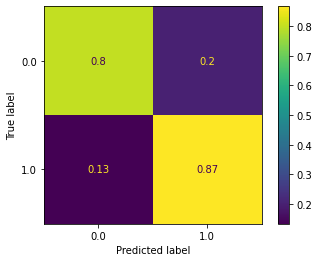

In [39]:
plot_confusion_matrix(model, X_test, X_test_["y_true"], normalize='true');

In [40]:
accuracy_score(y_test, y_pred, normalize=True)

0.8333333333333334

In [41]:
df_temp.head()

,Companhia Siderúrgica Nacional,ArcelorMittal NYSE,ArcelorMittal Amsterdam,Nippon Steel Corporation,Hesteel Group,POSCO,BRL to USD,rt_Companhia Siderúrgica Nacional,rt_ArcelorMittal NYSE,rt_ArcelorMittal Amsterdam,...,rt_Hesteel Group,rt_POSCO,rt_BRL to USD,cluster_rt_Companhia Siderúrgica Nacional,cluster_rt_ArcelorMittal NYSE,cluster_rt_ArcelorMittal Amsterdam,cluster_rt_Nippon Steel Corporation,cluster_rt_Hesteel Group,cluster_rt_POSCO,cluster_rt_BRL to USD
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-04,28.049999,113.220001,57.460354,2930.0,3.81,111.269997,1.6465,2.710193,-1.941810,-2.728396,...,0.000000,2.816314,1.900733,1.0,0.0,0.0,1.0,1.0,1.0,1.0
2011-01-05,28.750000,110.879997,56.645313,2900.0,3.78,112.400002,1.6675,2.464916,-2.088433,-1.428596,...,-0.790517,1.010430,1.267369,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2011-01-06,28.870001,107.669998,56.146099,2960.0,3.78,111.809998,1.6750,0.416526,-2.937753,-0.885205,...,0.000000,-0.526297,0.448763,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2011-01-07,29.049999,105.059998,55.422752,2920.0,3.84,108.599998,1.6859,0.621543,-2.453938,-1.296700,...,1.574834,-2.912959,0.648639,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2011-01-10,29.020000,103.589996,54.098312,2920.0,3.76,107.709999,1.6355,-0.103319,-1.409083,-2.418721,...,-2.105339,-0.822897,-3.035099,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [50]:
rt_mean = round(df_temp.groupby(by=["cluster_rt_Companhia Siderúrgica Nacional"]).agg(
    {"rt_Companhia Siderúrgica Nacional": ["min", "max","count", "mean"]}), 2)[("rt_Companhia Siderúrgica Nacional", "mean")]

conditions = [X_test_["y_pred"]==0, X_test_["y_pred"]==1]
choices = rt_mean.tolist()
X_test_["rt_predict"] = np.select(conditions, choices, default=np.nan)

rmse_uniform = mean_squared_error(y_test, X_test_["rt_predict"], squared=False)
print(f"RMSE para esse método: {round(rmse_uniform, 4)}%")

RMSE para esse método: 2.3166%


## Achando a estrutura da rede